# <ins>APPRENTISSAGE DES IMAGES AVEC VGG16</ins>

## <ins>CHARGEMENT DES LIBRAIRIES</ins>

In [1]:
import numpy as np
import pandas as pd
import json

from glob import glob
import pathlib
import os

import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import h5py
import keras
import projet_rakuten

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-08 19:01:55.367218: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 19:01:55.413178: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## <ins>CHARGEMENT DE NOTRE DATASET TRAIN</ins>

In [2]:
df_train = pd.read_csv('train_df.csv', index_col=[0])
df_train.prdtypecode = df_train.prdtypecode.astype(str)
df_train.filepath = df_train.filepath.astype(str)
df_train.filepath = df_train.filepath.str.replace('/train/', '/pretraitement/train/')
df_test = pd.read_csv('test_df.csv', index_col=[0])
df_test.prdtypecode = df_test.prdtypecode.astype(str)
df_test.filepath = df_test.filepath.astype(str)
df_test.filepath = df_test.filepath.str.replace('/train/', '/pretraitement/train/')
display(df_train.head())
display(df_test.head())

,prdtypecode,filepath,produit_clean
20801,10,./images/pretraitement/train/image_1296257106_...,music journal notebook white paper edition
34711,2705,./images/pretraitement/train/image_1113907088_...,paris plus belle vacances liliane après opérat...
46725,1280,./images/pretraitement/train/image_890867971_p...,doudou lapin patapouf kaloo peluche boule bleu...
14558,1280,./images/pretraitement/train/image_1282020176_...,buyiesky®peluche hiver bottes neige american g...
3039,1160,./images/pretraitement/train/image_900656095_p...,foil premium collecteur âmes magic mtg fleau mint


,prdtypecode,filepath,produit_clean
81417,1320,./images/pretraitement/train/image_1319550229_...,papier jouet tortue tirer jouet enfants bricol...
650,2060,./images/pretraitement/train/image_1289199379_...,leopard cristal acrylique géométrique miroir a...
7055,1280,./images/pretraitement/train/image_1098949166_...,boite musique noël wish you merry christmas bo...
15371,1140,./images/pretraitement/train/image_1176785754_...,funko pop vinyl nfl jason witten cowboy
72558,2583,./images/pretraitement/train/image_1247849820_...,kit piscine acier aspect bois gré sicilia oval...


## <ins>GENERATEUR DE DONNEES</ins>

Les transformations appliquées sur notre image seront :

- une fonction de prétraitement du modèle VGG16 : preprocess_input.
- une rotation aléatoire sur une plage de 10 degrés.
- une translation verticale et horizontale sur une plage de 10% des dimensions de l'images.
- un agrandissement sur une plage 10% de l'image.
- un retournement aléatoire horizontal de l'image.

In [3]:
from tensorflow.keras.applications.vgg16 import preprocess_input

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split = 0.15, rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.1, horizontal_flip = True)

test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

## <ins>CREATION D UN DATASET TENSORFLOW A PARTIR DES CHEMINS ET DES ETIQUETTES</ins>

## <ins>ITERATEUR</ins>

Cette méthode permettra de charger les images, de générér pour chaque iteration des lots de données (batchs) transformé par le générateur d'images.

In [4]:
BATCH_SIZE = 32


train_generator = train_data_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col = "filepath",
    y_col = "prdtypecode",
    target_size= (224,224),
    batch_size= BATCH_SIZE,
    class_mode= 'categorical',
    shuffle = True,
    subset = 'training'
    )

validation_generator = train_data_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col = "filepath",
    y_col = "prdtypecode",
    target_size= (224,224),
    batch_size= BATCH_SIZE,
    class_mode= 'categorical',
    shuffle = True,
    subset = 'validation'
    )

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col = "filepath",
    y_col = "prdtypecode",
    target_size= (224,224),
    batch_size= 1,
    class_mode= 'categorical',
    shuffle = False, 
    )

Found 48536 validated image filenames belonging to 27 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


Found 8565 validated image filenames belonging to 27 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


Found 19034 validated image filenames belonging to 27 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


##  <ins>CREATION DE NOTRE MODELE VGG AVEC 7 COUCHES SUPPLEMENTAIRES</ins>

In [5]:
from keras.applications.vgg16 import VGG16

n_class = 27

base_model = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

# blocage du backbone:
for layer in base_model.layers:
   layer.trainable = False  

inputs = keras.Input(shape= (224,224,3))

x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.BatchNormalization(trainable = True,axis=1)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization(trainable = True, axis=1)(x)
outputs = tf.keras.layers.Dense(n_class, activation="softmax")(x)

model = keras.Model(inputs = inputs, outputs = outputs)

model.summary()

2024-05-08 19:04:09.957752: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 19:04:09.964644: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 19:04:09.964679: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 19:04:09.967227: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 19:04:09.967263: I external/local_xla/xla/stream_executor

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │        13,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,784,795 (60.21 MB)

 Trainable params: 1,067,035 (4.07 MB)

 Non-trainable params: 14,717,760 (56.14 MB)

In [6]:
model.compile(loss=keras.losses.CategoricalFocalCrossentropy(), optimizer = 'adam', metrics=['accuracy'])

## <ins>DERNIERES PREPARATION - CALLBACKS</ins>

In [7]:

save_best_models_path = "/datas/sauvegarde_modele/vgg16_freeze_cropped/vgg16_callback.weights.h5"

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
                    
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_best_models_path, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')
                     
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1,  mode='min')

# Entrainement

callbacks = [model_checkpoint, reduce_lr, earlystopping]

## <ins>FIT DU MODELE VGG16</ins>

In [8]:
# entrainement avec la méthode .fit()
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715195054.840322     693 service.cc:145] XLA service 0x7f9fd8012910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715195054.840367     693 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-05-08 19:04:14.887441: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-08 19:04:15.198265: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:171

   1/1517 ━━━━━━━━━━━━━━━━━━━━ 8:07:44 19s/step - accuracy: 0.0312 - loss: 0.9578

I0000 00:00:1715195070.038455     693 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1464/1517 ━━━━━━━━━━━━━━━━━━━━ 17s 327ms/step - accuracy: 0.3815 - loss: 0.4672

I0000 00:00:1715195550.371881     867 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2314', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1715195550.486958     869 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2314', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1715195550.498672     870 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2314', 32 bytes spill stores, 32 bytes spill loads



1517/1517 ━━━━━━━━━━━━━━━━━━━━ 626s 400ms/step - accuracy: 0.3831 - loss: 0.4647 - val_accuracy: 0.5026 - val_loss: 0.3171 - learning_rate: 0.0010
Epoch 2/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 522s 342ms/step - accuracy: 0.4856 - loss: 0.3220 - val_accuracy: 0.5110 - val_loss: 0.3043 - learning_rate: 0.0010
Epoch 3/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 519s 341ms/step - accuracy: 0.5098 - loss: 0.2988 - val_accuracy: 0.5347 - val_loss: 0.2908 - learning_rate: 0.0010
Epoch 4/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 522s 343ms/step - accuracy: 0.5232 - loss: 0.2863 - val_accuracy: 0.5374 - val_loss: 0.2877 - learning_rate: 0.0010
Epoch 5/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 515s 338ms/step - accuracy: 0.5388 - loss: 0.2725 - val_accuracy: 0.5365 - val_loss: 0.2835 - learning_rate: 0.0010
Epoch 6/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 523s 343ms/step - accuracy: 0.5445 - loss: 0.2667 - val_accuracy: 0.5524 - val_loss: 0.2840 - learning_rate: 0.0010
Epoch 7/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 518s 340ms/step - acc

In [11]:
# Chemin pour enregistrer le modèle
model_path = './sauvegarde_modele/vgg16/vgg16_crpped.keras'

# Save the cloned model
model.save(model_path)

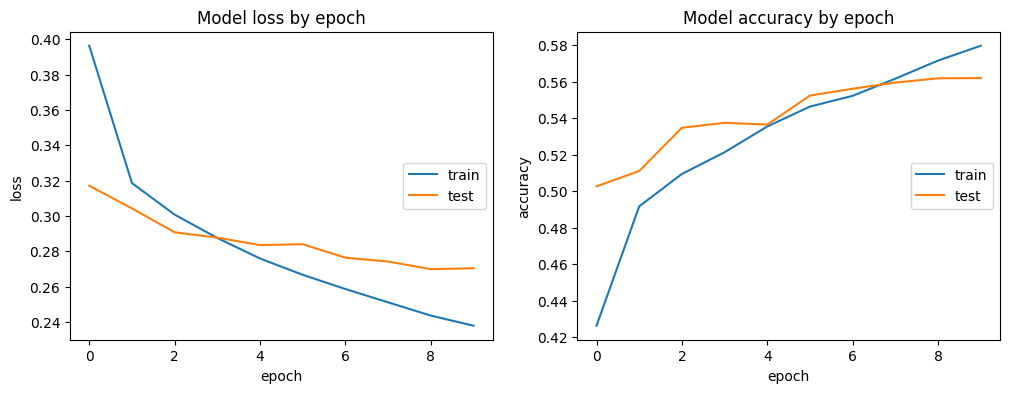

In [12]:

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

Recupération des probabilités renvoyés par le modèke pour les 19034 images à 13:27:19


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19034/19034 ━━━━━━━━━━━━━━━━━━━━ 185s 10ms/step
Fin de la récupération à 13:30:32
Délai du modèle pour la prédiction :  0:03:12.359447
ACCURACY DU MODELE :  0.5716612377850163

F1_SCORE_WEIGHTED :  0.5599004747256071

              precision    recall  f1-score   support

          10       0.42      0.30      0.35       649
        1140       0.62      0.57      0.59       509
        1160       0.87      0.87      0.87       691
        1180       0.50      0.26      0.34       148
        1280       0.45      0.37      0.41      1105
        1281       0.33      0.28      0.30       499
        1300       0.57      0.60      0.58      1176
        1301       0.61      0.54      0.57       159
        1302       0.37      0.47      0.42       593
        1320       0.41      0.46      0.44       705
        1560       0.57      0.59      0.58      1298
        1920       0.73      0.80      0.76       988
        1940       0.81      0.60      0.69       172
        2060       0.49  

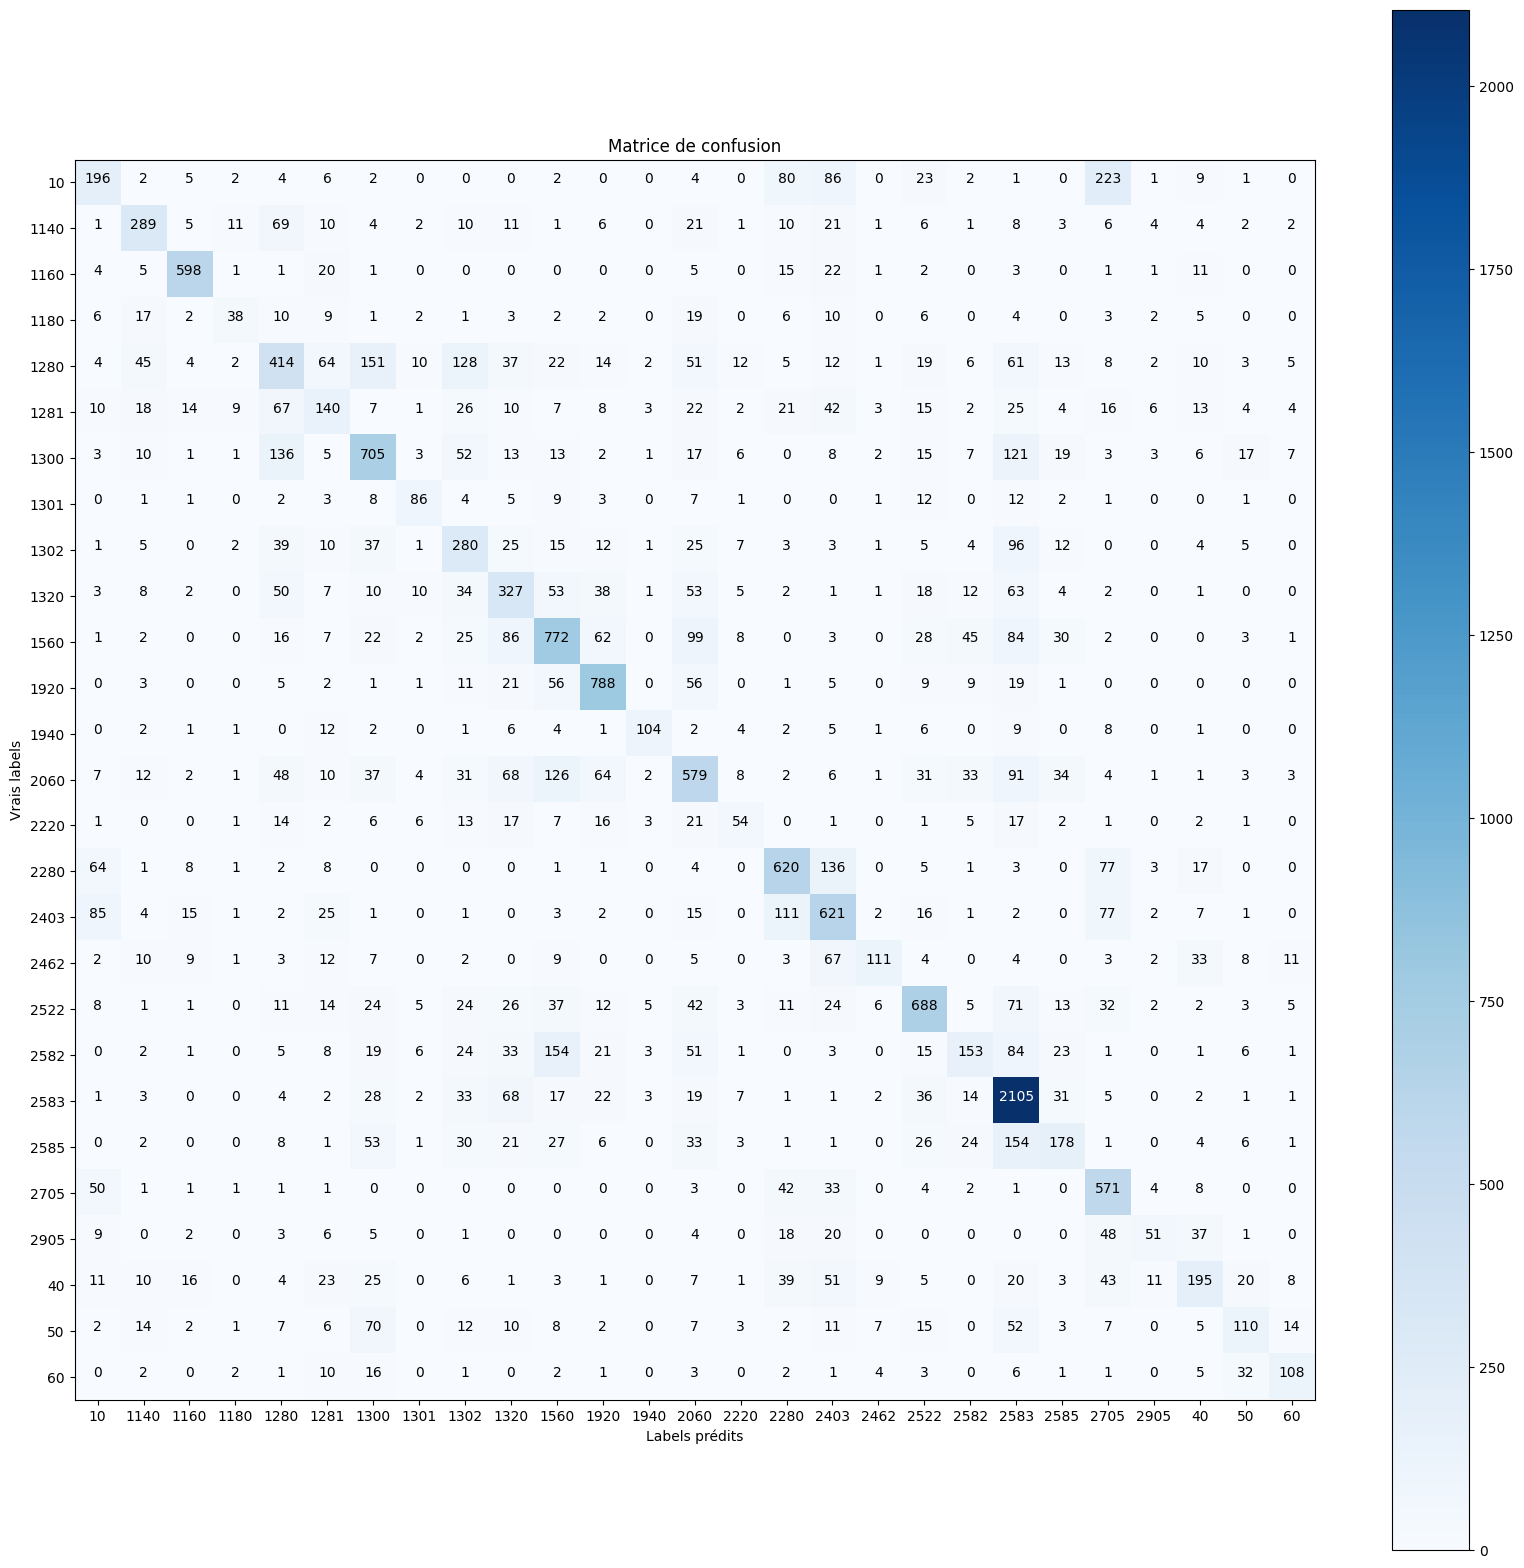

In [13]:
from projet_rakuten import predict_effnet

y_prob, y_pred, y_test, class_labels = predict_effnet(test_generator, model)

## <ins>DE-FREEZ DES 8 DERNIERES COUCHES DE NOTRE MODELE VGG16</ins>

Lors de l'apprentissage précédent, nous avons "freezé" les poids du modèle VGG16 CNN puisqu'ils étaient proches des poids optimaux et que les poids du classifieur étaient initialisés de manière aléatoire.

Nous allons maintenant rechercher une meilleure solution en reprenant notre modèle appris précédément et "dé-freezer" les couches les unes après les autres du vgg16 . De plus, nous utilisons une learning rate plus faible pour ajuster plus finement les paramètres.

In [ ]:
for layer in base_model.layers[-8:]:
    layer.trainable = True

lr = 0.0001
optimizer = Adam(learning_rate=lr)

# compile avec modification de l'optimizer
model.compile(loss=keras.losses.CategoricalFocalCrossentropy(), optimizer = optimizer, metrics=['accuracy'])

save_best_models_path = "./sauvegarde_modele/vgg16_unfreeze_cropped/vgg16_unfreeze.weights.h5"

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
                    
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_best_models_path, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')
                     
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1,  mode='min')

# Entrainement

callbacks = [model_checkpoint, reduce_lr, earlystopping]

# entrainement avec la méthode .fit()
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks)

## <ins>SAUVEGARDE DE NOTRE MODELLE</ins>

In [15]:
# Chemin pour enregistrer le modèle
model_path = './sauvegarde_modele/vgg16/vgg16_unfreeze_cropped.keras'

# Enregistrement du modèle
model.save(model_path)

## <ins>AFFICHAGE DE LA COURBE FONCTION COUT ET PRECISION EN FONCTION DE L EPOCH</ins>

In [ ]:

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

#### SCORES

In [ ]:
from projet_rakuten import predict_effnet

y_prob, y_pred, y_test, class_labels = predict_effnet(test_generator, model)